# Data Literacy Project – Analyzing the Similarity of Covid-19 Time Series Pattern
University of Tuebingen, Winter Term 2021/2022
#### Xuanhao Cao, Dorothee Sigg

In [129]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import tslearn.clustering as tsc
from tslearn.utils import to_time_series_dataset
from math import ceil, prod
from iso3166 import countries

In [5]:
# load data from countries all over the world

url = 'https://github.com/owid/covid-19-data/raw/master/public/data/jhu/weekly_cases_per_million.csv'
data_world = pd.read_csv(url)

# Inspect first few rows of the data
print('Number of rows (=days) in the dataframe: ', len(data_world))
print('Number of columns (=countries) in the dataframe: ', len(data_world.columns))
data_world.head()

Number of rows (=days) in the dataframe:  735
Number of columns (=countries) in the dataframe:  230


,date,World,Afghanistan,Africa,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,...,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Wallis and Futuna,Yemen,Zambia,Zimbabwe
0,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data_countries_pd = data_world.drop(['date', 'World'], axis=1)
data_countries = data_countries_pd.to_numpy()
dates = pd.to_datetime(data_world['date'])
print(data_countries.shape)

(735, 228)


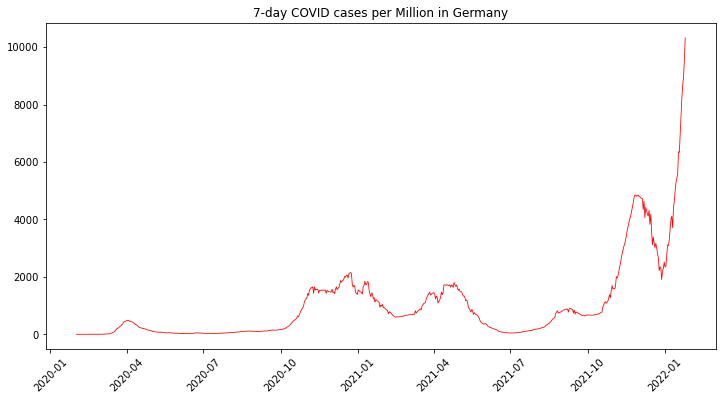

In [7]:
# look exemplarily at the data of Germany
plt.figure(figsize=(12, 6))
plt.plot(dates, data_world['Germany'], linewidth=0.8, color='r')
plt.tick_params('x', labelrotation=45)
plt.title('7-day COVID cases per Million in Germany')
plt.show()

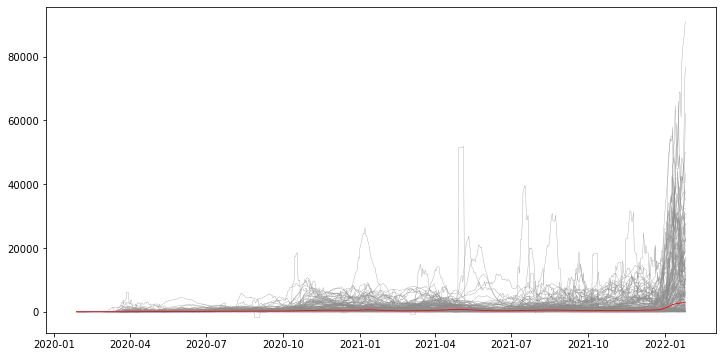

In [8]:
# plotting the cases for each country
plt.figure(figsize=(12, 6))
plt.plot(dates, data_countries, linewidth=0.3, color='0.55')
plt.plot(dates, data_world['World'], linewidth=0.8, color='r')
plt.show()

#### Europe

In [10]:
# as an example: concentrate on european union first

from countrygroups import EUROPEAN_UNION
len(EUROPEAN_UNION.names)

data_eu = pd.DataFrame(data_world['date'])

for c in data_world.columns:
    if c in EUROPEAN_UNION.names:
        data_eu[c] = data_world[c]

data_eu = data_eu.dropna()
data_eu = data_eu.drop(['date'], axis=1).to_numpy()


#for i in range(2, 10): 
#    print(data_eu.T.shape)
#    model = tsc.TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=30, n_init=1)
#    print(model.fit_predict(data_eu.T))

#### Whole world
>Step 1: Preprocess
>    - remove pseudo countries
>    - handle NaNs (mixture of remove and interpolate)

In [47]:
# preprocess: remove 'countries', which are not countries (e.g. 'high income')
if 'date' in data_world.columns:
    data_world = data_world.set_index('date')

not_country = []
for col in data_world.columns:
    if col not in countries: 
        not_country.append(col)
# print(is_country)
# hand-pick from that list
not_country = ['World', 'Africa', 'Asia', 'Europe', 'European Union', 'High income', 'International', 
               'Lower middle income', 'North America', 'Oceania', 'South America', 'Summer Olympics 2020', 
               'Upper middle income']
print('Removed the following columns, because they are not a country:')
print(*not_country, sep = "\n")
data_countries = data_world.drop(not_country, axis=1)



Removed the following columns, because they are not a country:
World
Africa
Asia
Europe
European Union
High income
International
Lower middle income
North America
Oceania
South America
Summer Olympics 2020
Upper middle income


In [124]:
# version 1
# preprocess: interpolation of NaNs and removing remaining NaNs

data_interpol = data_countries.apply(func=lambda x: x.interpolate())
print('Interpolating: Removed', data_countries.isna().sum().sum()-data_interpol.isna().sum().sum(), 'NaN values.')
# 
data_cropped = data_interpol.dropna(thresh=ceil(0.8*len(data_interpol.columns)))
print('Cropping: Removed', data_interpol.isna().sum().sum()-data_cropped.isna().sum().sum(), 'NaN values.')

data = data_cropped.dropna(axis=1)
print('\nAdditionally removed', len(data_interpol.columns)-len(data.columns), 'countries due to missing data:\n')
removed_countries = list(set(data_cropped.columns).symmetric_difference(set(data.columns)))
print(*removed_countries, sep = "\n")


Interpolating: Removed 43 NaN values.
Cropping: Removed 10283 NaN values.

Additionally removed 41 countries due to missing data:

Saint Kitts and Nevis
Guinea-Bissau
Timor
Uganda
Falkland Islands
Eritrea
Vanuatu
Cook Islands
Malawi
Solomon Islands
South Sudan
Botswana
Burundi
British Virgin Islands
Belize
Bonaire Sint Eustatius and Saba
Mozambique
Turks and Caicos Islands
Micronesia (country)
Palau
Syria
Yemen
Anguilla
Marshall Islands
Samoa
Sao Tome and Principe
Saint Helena
Laos
Dominica
Myanmar
Tonga
Kiribati
Sierra Leone
Wallis and Futuna
Libya
Grenada
Lesotho
Saint Pierre and Miquelon
Tajikistan
Comoros
Mali


In [179]:
# version 2
# interpolate NaNs (in the middle), but using flexibility of TimeSeriesKMeans to handle different-length time series

# first: NaNs must be at shifted to the end of time series
print(data_interpol.shape)
data_shifted = data_interpol.apply(lambda x: sorted(x, key=pd.isna), axis=0)

# bring in correct format
data_ts = to_time_series_dataset(data_shifted.T)
print(data_ts.shape)
print('Fraction of NaNs: ', round((np.isnan(data_ts).sum()/prod(data_ts.shape))*100, 2), '%.\n')

(735, 216)
(216, 729, 1)
Fraction of NaNs:  8.19 %.



In [135]:
# using time series k-means algorithm
n_clusters = 8
# using version 1
model = tsc.TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=30)
km1 = model.fit_predict(data.T)
print(km1)

# using version 2
model2 = tsc.TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=30)
km2 = model2.fit_predict(data_ts)
print(km2)

[1 4 1 3 1 0 4 5 4 2 5 7 1 4 7 1 7 1 7 7 1 7 1 4 2 4 4 4 2 1 4 1 1 1 1 4 0
 2 1 1 4 1 4 1 1 1 4 1 7 4 2 6 7 1 3 1 4 1 1 1 1 1 1 7 4 1 3 1 4 4 6 0 1 1
 7 4 1 2 5 2 7 1 1 1 4 1 1 1 4 5 1 1 1 1 0 2 3 5 1 1 4 4 1 1 4 4 1 1 7 4 1
 1 1 5 7 1 6 1 1 1 4 7 1 0 1 1 1 1 1 4 5 4 7 4 1 1 1 4 1 7 4 1 1 1 1 4 5 1
 1 5 4 5 1 4 4 1 4 6 4 4 1 1 1 0 7 3 4 1 6 1 1 1 7 2 1 4 7 6 1 1 1 1 1 5 1
 1 4 6 6 1 1 1 1 1 1 1 1 4 4 4 0 1 4 1 0 5 6 1 1 4 1 1 4 1 1 1]


In [137]:
# compute silhouette score (-1 for incorrect clustering and +1 for highly dense clustering)
sc = tsc.silhouette_score(data_ts, km2, metric="dtw")
print('silhouette score:', sc)

silhouette score: 0.47387692011052873


In [141]:
sc = tsc.silhouette_score(data.T, km1, metric="dtw")
print('silhouette score:', sc)

silhouette score: 0.4373949392145835


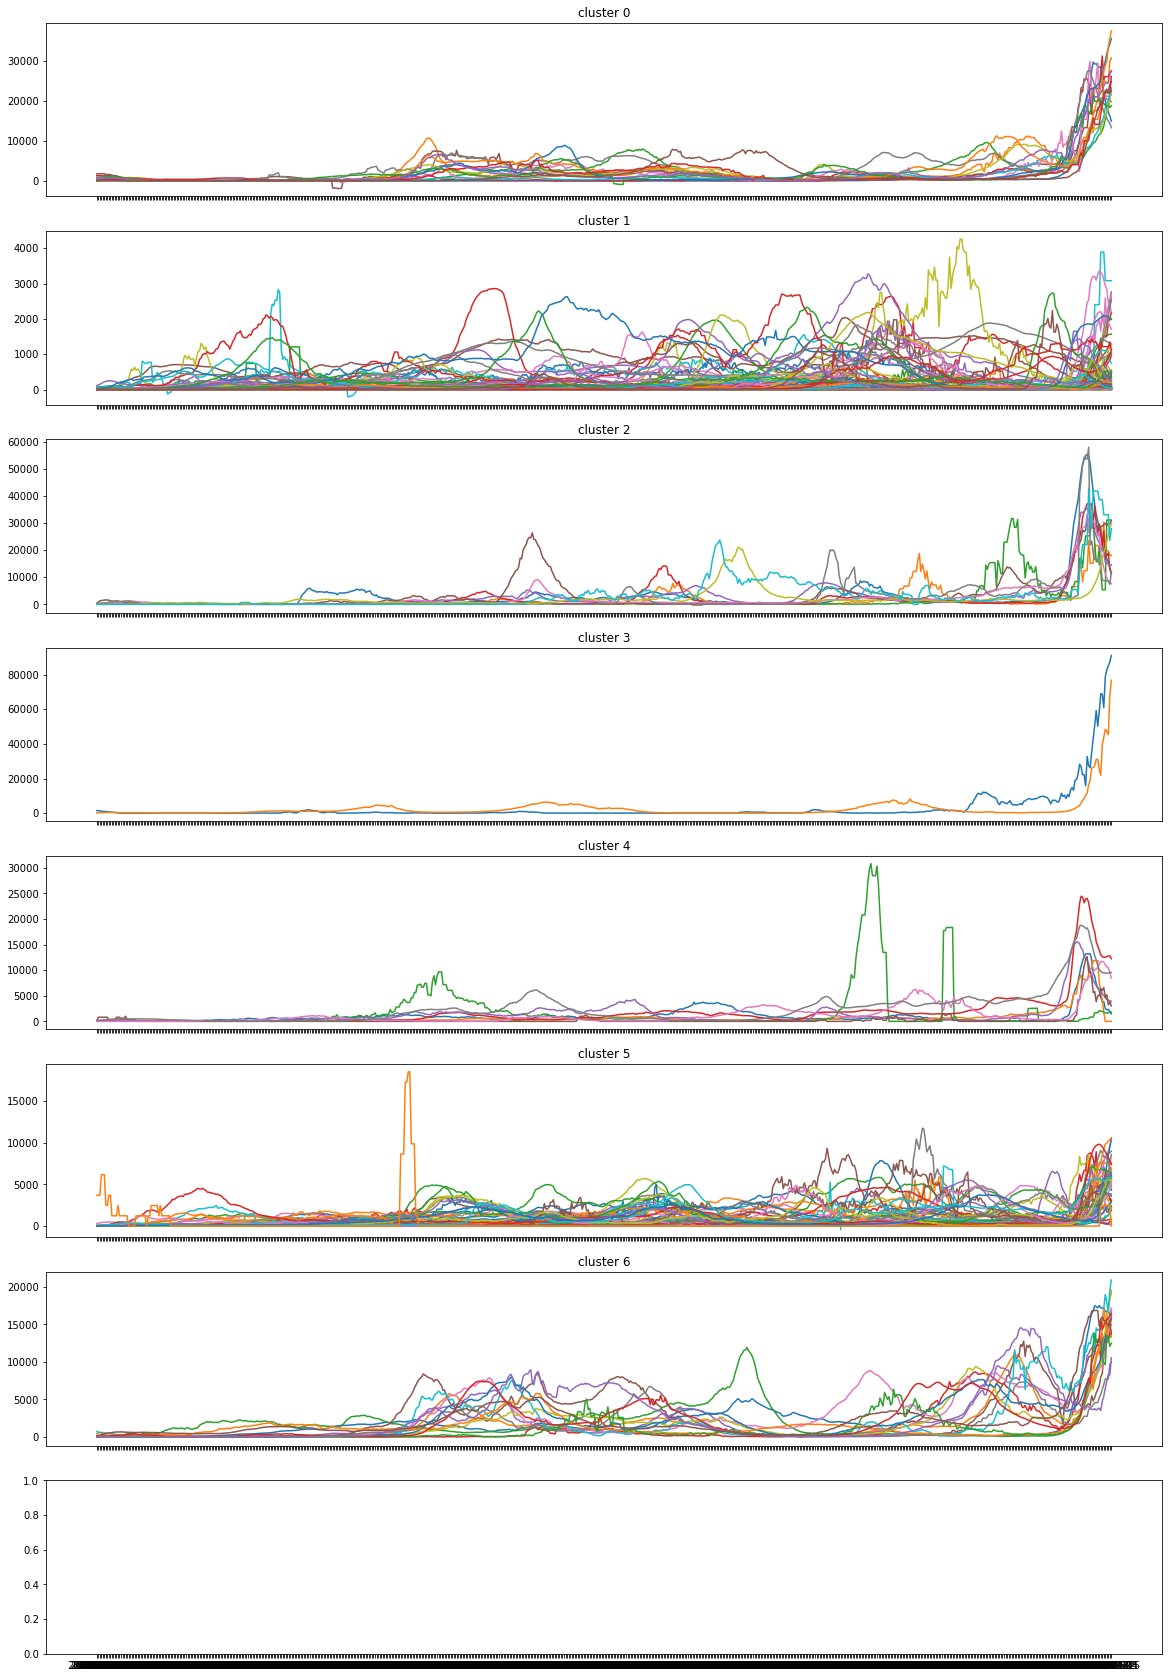

In [178]:
# plot clusterings
n_clusters = 8
fig, axs = plt.subplots(n_clusters, 1, sharex=True, sharey=False, figsize=(20, 30))
for c in range(n_clusters-1):
    b = [c==label for label in km1]
    axs[c].plot(data.T.iloc[b].T)
    axs[c].set_title(f'cluster {c}')


In [102]:
# iterating over hyperparameter (n_clusters, metric, version of preprocessing)
# using silhouette score to evaluate clustering
ks = range(4, 10, 2)
print(ks)
metrics = ['dtw', 'softdtw', 'euclidean']
data_version = [data_ts, data.T]
for d in range(1):
    for k in ks:
        for m in metrics: 
            print('Using k =', k, m)
            model = tsc.TimeSeriesKMeans(n_clusters=k, metric=m, max_iter=30)
            labels = model.fit_predict(data_version[d])
            # print(labels)
            sc = silhouette_score(data_version[d], labels, metric=m)
            print('silhouette score:', round(sc, 4))

/Users/dorotheesigg/opt/anaconda3/envs/project/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 162 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


[0 0 0 7 0 6 0 2 3 6 0 4 5 3 7 7 0 2 0 5 1 0 7 7 3 7 0 0 0 7 0 0 3 0 7 7 2
 3 1 4 5 0 5 0 0 0 0 5 3 0 2 2 0 7 7 0 1 4 6 0 7 0 2 0 0 7 4 0 0 3 0 4 6 1
 4 0 0 3 7 0 7 7 0 7 7 0 5 7 0 0 5 0 3 1 2 0 0 3 4 5 7 0 3 0 2 7 0 0 0 2 7
 2 2 3 0 3 2 0 7 0 7 5 2 7 0 0 2 3 1 0 0 5 1 3 2 5 0 7 0 4 0 0 2 5 5 0 0 0
 7 7 3 3 2 2 0 5 0 7 0 0 0 0]
